In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **Importing and Constructing Dataset**

In [ ]:
INPUT_PATH = '/content/drive/MyDrive/Dataset/ransomwaredataset2016-main/'

f1= open(INPUT_PATH + 'VariableNames.txt', encoding = 'utf-8')
columns=[]
for i in f1:
    column = i.split(';')
    columns.append(column[1].replace('\n', ''))



data = pd.read_csv(INPUT_PATH + 'RansomwareData.csv', header=None,names=columns)


In [ ]:
print(data.shape)


(1524, 30970)


In [ ]:
dataset_temp =  data.loc[:, (data != data.iloc[0]).any()]

dataset = dataset_temp.drop(['ID', 'Ransomware Family'], axis =1)
dataset.head()

,Label (1 Ransomware / 0 Goodware),API:GetSystemDirectoryA,API:WriteConsoleA,API:NtOpenFile,API:NtCreateProcessEx,API:GetSystemInfo,API:WriteConsoleW,API:NtReadVirtualMemory,API:RemoveDirectoryA,API:GetKeyState,...,STR:16247,STR:16252,STR:16253,STR:16255,STR:16256,STR:16259,STR:16260,STR:16261,STR:16264,STR:16267
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


# **Train-Test Split**

In [ ]:
X= dataset.drop(columns='Label (1 Ransomware / 0 Goodware)', axis =1)
Y= dataset['Label (1 Ransomware / 0 Goodware)']

In [ ]:
from sklearn.model_selection import train_test_split
X_temp, X_test_temp, Y_temp, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 1)
print(X_temp.shape)


(1219, 23616)


# **Feature Selection and Automation**

## *Variance Threshold*

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
threshold = 0.001

selector = VarianceThreshold(threshold=threshold)
selector.fit_transform(X_temp)
num_feats = selector.n_features_in_
features_selected = selector.get_feature_names_out()

X_temp_select = X_temp[features_selected]
X_test = X_test_temp[features_selected]

print(len(X_temp_select.columns))
print(X_test.shape)

4671
(305, 4671)


##  *Information Gain*

In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
acc_list = []
for p in range(25, 101, 25):
  selected_top_columns = SelectPercentile(mutual_info_classif, percentile=p)
  selected_top_columns.fit(X_train, Y_train)
  features_selected = X_train.columns[selected_top_columns.get_support()]
  X_train_select = X_train[features_selected]
  X_test_select = X_test[features_selected]
  model_DTC = DecisionTreeClassifier(max_leaf_nodes = 25, min_samples_split = 4, random_state = 42)
  history1 = model_DTC.fit(X_train_select, Y_train)
  y_pred = model_DTC.predict(X_test_select)
  acc_list.append(accuracy_score(y_pred, Y_test))


## *Chi Square*

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

acc_list_chi2 = []
for p in range(1, 100, 1):
  selectChi2 = SelectPercentile(chi2, percentile=25).fit(X_train, Y_train)
  chi2_selected = selectChi2.get_support()
  features_selected = X_train.columns[chi2_selected]
  X_train_select = X_train[features_selected]
  X_test_select = X_test[features_selected]
  model_DTC = DecisionTreeClassifier(max_leaf_nodes = 25, min_samples_split = 4, random_state = 42)
  history1 = model_DTC.fit(X_train_select, Y_train)
  y_pred = model_DTC.predict(X_test_select)
  acc_list_chi2.append(accuracy_score(y_pred, Y_test))

## *Mean Absolute Difference(MAD)*

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def mean_absolute_difference(X, Y):
    abs_diff = np.abs(X - Y)
    mad = np.mean(abs_diff, axis=0)
    return mad

mad_scores = mean_absolute_difference(X_train, Y_train)
def custom_score_function(X, Y):
    return mad_scores
acc_list_mad = []

for p in range(1,100,1):
    mad_selector = SelectPercentile(score_func= custom_score_function, percentile=25)
    mad_selector.fit(X_train, Y_train)
    indices = mad_selector.get_support(indices=True)
    features_selected = X_train.columns[indices]
    X_train_select = X_train[features_selected]
    X_test_select = X_test[features_selected]
    model_DTC = DecisionTreeClassifier(max_leaf_nodes = 25, min_samples_split = 4, random_state = 42)
    history1 = model_DTC.fit(X_train_select, Y_train)
    y_pred = model_DTC.predict(X_test_select)
    acc_list_mad.append(accuracy_score(y_pred, Y_test))

In [ ]:
plt.plot(range(1, 100, 1), acc_list_mad, label='Percentile of Features Used vs Accuracy')
plt.xlabel('Percentile')
plt.ylabel('Accuracy')


Splitting into X_temp into Training and Validation data

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_temp_select,Y_temp, test_size = 0.30, random_state = 42)
print(X_train.shape)
print(X_val.shape)

(853, 4671)
(366, 4671)


# **Machine Learning Models**

## *1. Decision Tree Classifier*

Training and Validation with 100 epoch of steps 10

Step 10: Training Accuracy = 0.5991, Validation Accuracy = 0.6311
Step 20: Training Accuracy = 0.7104, Validation Accuracy = 0.7049
Step 30: Training Accuracy = 0.6401, Validation Accuracy = 0.6585
Step 40: Training Accuracy = 0.7222, Validation Accuracy = 0.6967
Step 50: Training Accuracy = 0.7691, Validation Accuracy = 0.7678
Step 60: Training Accuracy = 0.8066, Validation Accuracy = 0.8060
Step 70: Training Accuracy = 0.8851, Validation Accuracy = 0.8579
Step 80: Training Accuracy = 0.8980, Validation Accuracy = 0.8579
Step 90: Training Accuracy = 0.8910, Validation Accuracy = 0.8552
Step 100: Training Accuracy = 0.8898, Validation Accuracy = 0.8470


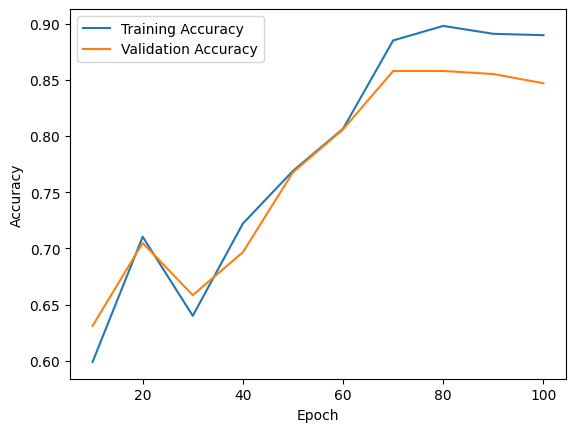

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning

model_DTC = DecisionTreeClassifier(max_leaf_nodes = 25, min_samples_split = 4, random_state = 42)

warnings.filterwarnings("ignore", category=ConvergenceWarning)

training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):

    model_DTC.fit(X_train[:step], Y_train[:step])

    train_predictions = model_DTC.predict(X_train)

    val_predictions = model_DTC.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)


    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Testing

In [ ]:
from sklearn import metrics
model_DTC = DecisionTreeClassifier(max_leaf_nodes = 25, min_samples_split = 4, random_state = 42)
model_DTC.fit(X_train, Y_train)
y_pred = model_DTC.predict(X_test)
print(f'Accuracy for decision tree model is : {(accuracy_score(y_pred, Y_test)*100)} %')

C = metrics.confusion_matrix(Y_test,y_pred)
tn, fp, fn, tp = C.ravel()
print()
print(f'False Positive Calculted : {(fp / (fp + tn))*100} %')
print(f'False Negative Calculted : {(fn / (fn + tp))*100} %')

Accuracy for decision tree model is : 97.70491803278688 %

False Positive Calculted : 2.127659574468085 %
False Negative Calculted : 2.564102564102564 %


## *2. Random Forest Classifier*

Training and Validation of 100 epoch of step 10

Epoch 10: Training Accuracy = 0.8886, Validation Accuracy = 0.8634
Epoch 20: Training Accuracy = 0.9074, Validation Accuracy = 0.8716
Epoch 30: Training Accuracy = 0.9039, Validation Accuracy = 0.8634
Epoch 40: Training Accuracy = 0.9004, Validation Accuracy = 0.8552
Epoch 50: Training Accuracy = 0.8992, Validation Accuracy = 0.8689
Epoch 60: Training Accuracy = 0.8968, Validation Accuracy = 0.8579
Epoch 70: Training Accuracy = 0.8921, Validation Accuracy = 0.8579
Epoch 80: Training Accuracy = 0.8992, Validation Accuracy = 0.8689
Epoch 90: Training Accuracy = 0.8992, Validation Accuracy = 0.8716
Epoch 100: Training Accuracy = 0.9004, Validation Accuracy = 0.8689


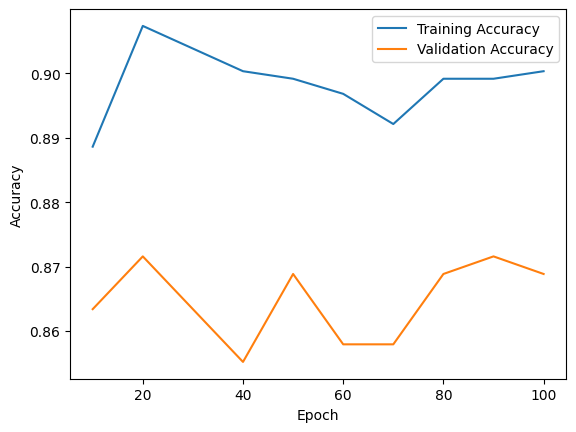

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

model_RFC = RandomForestClassifier(n_estimators=100, max_depth=5)
n_estimators = 100
training_accuracy = []
validation_accuracy = []

for epoch in range(10, n_estimators + 1, 10):
    model_RFC.set_params(n_estimators=epoch)
    model_RFC.fit(X_train, Y_train)

    train_predictions = model_RFC.predict(X_train)

    val_predictions = model_RFC.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Epoch {epoch}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, n_estimators + 1, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, n_estimators + 1, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Testing

In [ ]:
model_RFC = RandomForestClassifier(n_estimators=100, max_depth=5)
model_RFC.fit(X_train,Y_train)
y_pred = model_RFC.predict(X_test)
print(f'Accuracy for Random Forest classifier model is : {(accuracy_score(Y_test,y_pred))*100} %')

C = confusion_matrix(Y_test,y_pred)
tn, fp, fn, tp = C.ravel()
print()
print(f'False Positive Calculted : {(fp / (fp + tn))*100} %')
print(f'False Negative Calculted : {(fn / (fn + tp))*100} %')

Accuracy for Random Forest classifier model is : 88.19672131147541 %

False Positive Calculted : 15.425531914893616 %
False Negative Calculted : 5.982905982905983 %


## *3. Logistic Regression*

Training and Validation of 100 epoch of step 10

Step 10: Training Accuracy = 0.6143, Validation Accuracy = 0.6448
Step 20: Training Accuracy = 0.6190, Validation Accuracy = 0.6475
Step 30: Training Accuracy = 0.6612, Validation Accuracy = 0.6721
Step 40: Training Accuracy = 0.7421, Validation Accuracy = 0.7350
Step 50: Training Accuracy = 0.9074, Validation Accuracy = 0.9098
Step 60: Training Accuracy = 0.9226, Validation Accuracy = 0.9208
Step 70: Training Accuracy = 0.9379, Validation Accuracy = 0.9235
Step 80: Training Accuracy = 0.9484, Validation Accuracy = 0.9344
Step 90: Training Accuracy = 0.9414, Validation Accuracy = 0.9208
Step 100: Training Accuracy = 0.9379, Validation Accuracy = 0.9180


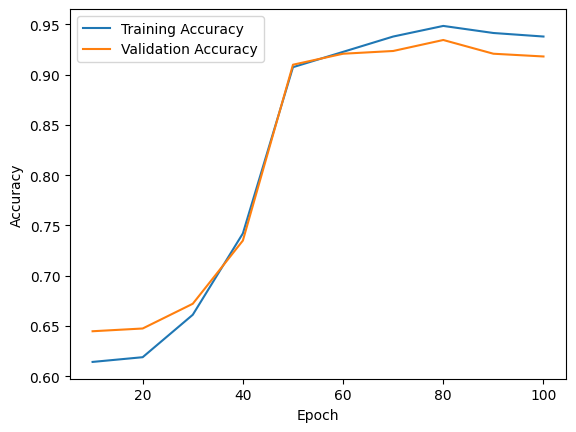

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning


model_LRC = LogisticRegression(max_iter=1000)

warnings.filterwarnings("ignore", category=ConvergenceWarning)

training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):

    model_LRC.fit(X_train[:step], Y_train[:step])

    train_predictions = model_LRC.predict(X_train)

    val_predictions = model_LRC.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Testing

In [ ]:
model_LRC = LogisticRegression(max_iter=1000)
model_LRC.fit(X_train,Y_train)
y_pred = model_LRC.predict(X_test)
print(f'Accuracy for Logistic Regression classifier model is : {accuracy_score(y_pred, Y_test)*100} %')

C = confusion_matrix(Y_test,y_pred)
tn, fp, fn, tp = C.ravel()
print()
print(f'False Positive Calculted : {(fp / (fp + tn))*100} %')
print(f'False Negative Calculted : {(fn / (fn + tp))*100} %')

Accuracy for Logistic Regression classifier model is : 97.37704918032787 %

False Positive Calculted : 1.0638297872340425 %
False Negative Calculted : 5.128205128205128 %


## *4. Support Vector Machine*

Training and Validation of 100 epoch of step 10

Step 10: Training Accuracy = 0.6084, Validation Accuracy = 0.6421
Step 20: Training Accuracy = 0.6084, Validation Accuracy = 0.6421
Step 30: Training Accuracy = 0.6377, Validation Accuracy = 0.6612
Step 40: Training Accuracy = 0.6401, Validation Accuracy = 0.6612
Step 50: Training Accuracy = 0.8206, Validation Accuracy = 0.8060
Step 60: Training Accuracy = 0.8335, Validation Accuracy = 0.8197
Step 70: Training Accuracy = 0.8617, Validation Accuracy = 0.8443
Step 80: Training Accuracy = 0.8640, Validation Accuracy = 0.8443
Step 90: Training Accuracy = 0.8710, Validation Accuracy = 0.8525
Step 100: Training Accuracy = 0.8675, Validation Accuracy = 0.8497


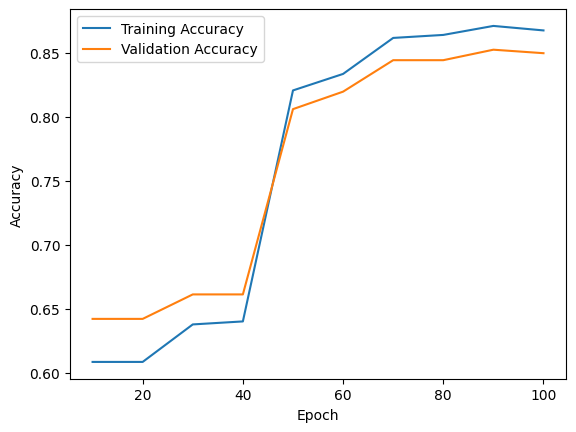

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning

model_SVC = SVC()

warnings.filterwarnings("ignore", category=ConvergenceWarning)


training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):

    model_SVC.fit(X_train[:step], Y_train[:step])


    train_predictions = model_SVC.predict(X_train)

    val_predictions = model_SVC.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Testing

In [ ]:
model_SVC = SVC()
model_SVC.fit(X_train,Y_train)
y_pred = model_SVC.predict(X_test)
print(f'Accuracy for Support Vector classifier model is : {accuracy_score(y_pred, Y_test)*100} %')

C = confusion_matrix(Y_test,y_pred)
tn, fp, fn, tp = C.ravel()
print()
print(f'False Positive Calculted : {(fp / (fp + tn))*100} %')
print(f'False Negative Calculted : {(fn / (fn + tp))*100} %')

Accuracy for Support Vector classifier model is : 95.08196721311475 %

False Positive Calculted : 1.0638297872340425 %
False Negative Calculted : 11.11111111111111 %


## *5. Gaussian Naive Bayes*

Training and Validation of 100 epoch of step 10

Step 10: Training Accuracy = 0.6237, Validation Accuracy = 0.6475
Step 20: Training Accuracy = 0.6190, Validation Accuracy = 0.6557
Step 30: Training Accuracy = 0.6835, Validation Accuracy = 0.7022
Step 40: Training Accuracy = 0.7819, Validation Accuracy = 0.8033
Step 50: Training Accuracy = 0.8300, Validation Accuracy = 0.8388
Step 60: Training Accuracy = 0.7937, Validation Accuracy = 0.8087
Step 70: Training Accuracy = 0.8593, Validation Accuracy = 0.8251
Step 80: Training Accuracy = 0.8699, Validation Accuracy = 0.8333
Step 90: Training Accuracy = 0.8804, Validation Accuracy = 0.8443
Step 100: Training Accuracy = 0.8746, Validation Accuracy = 0.8443


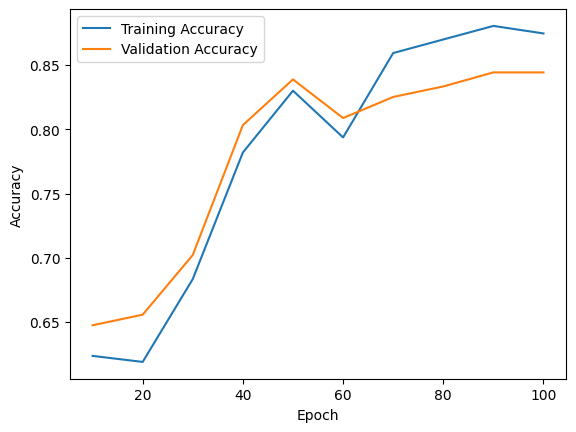

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning

model_GNB = GaussianNB()

warnings.filterwarnings("ignore", category=ConvergenceWarning)

training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):

    model_GNB.fit(X_train[:step], Y_train[:step])

    train_predictions = model_GNB.predict(X_train)

    val_predictions = model_GNB.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Testing

In [ ]:
model_GNB = GaussianNB()
model_GNB.fit(X_train, Y_train)
y_pred = model_GNB.predict(X_test)
print(f'Accuracy for Gaussian Naive Bayes classifier model is : {accuracy_score(y_pred, Y_test)*100} %')

C = confusion_matrix(Y_test,y_pred)
tn, fp, fn, tp = C.ravel()
print()
print(f'False Positive Calculted : {(fp / (fp + tn))*100} %')
print(f'False Negative Calculted : {(fn / (fn + tp))*100} %')

Accuracy for Gaussian Naive Bayes classifier model is : 89.50819672131148 %

False Positive Calculted : 13.829787234042554 %
False Negative Calculted : 5.128205128205128 %


## *6. ADABoost*

Training and Validation of 100 epoch of step 10

Step 10: Training Accuracy = 0.6131, Validation Accuracy = 0.6421
Step 20: Training Accuracy = 0.6706, Validation Accuracy = 0.6667
Step 30: Training Accuracy = 0.6448, Validation Accuracy = 0.6585
Step 40: Training Accuracy = 0.8113, Validation Accuracy = 0.8306
Step 50: Training Accuracy = 0.8148, Validation Accuracy = 0.8142
Step 60: Training Accuracy = 0.8417, Validation Accuracy = 0.8579
Step 70: Training Accuracy = 0.8593, Validation Accuracy = 0.8497
Step 80: Training Accuracy = 0.8640, Validation Accuracy = 0.8552
Step 90: Training Accuracy = 0.8992, Validation Accuracy = 0.9071
Step 100: Training Accuracy = 0.8652, Validation Accuracy = 0.8552


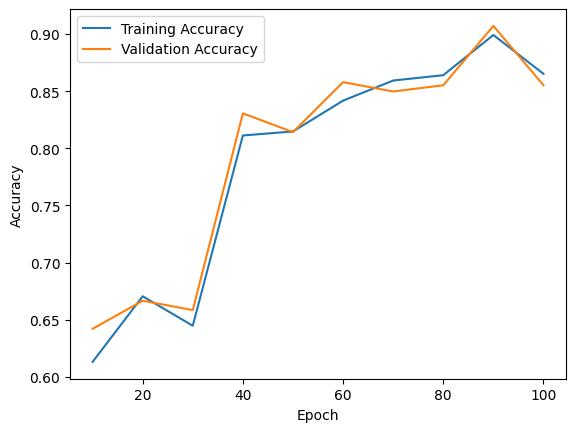

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning

model_ADA = AdaBoostClassifier()

warnings.filterwarnings("ignore", category=ConvergenceWarning)

training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):

    model_ADA.fit(X_train[:step], Y_train[:step])

    train_predictions = model_ADA.predict(X_train)

    val_predictions = model_ADA.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Testing

In [ ]:
model_ADA = AdaBoostClassifier()
model_ADA.fit(X_train,Y_train)
y_pred = model_ADA.predict(X_test)
print(f'Accuracy for ADA boost model is : {accuracy_score(y_pred, Y_test)*100} %')

C = confusion_matrix(Y_test,y_pred)
tn, fp, fn, tp = C.ravel()
print()
print(f'False Positive Calculted : {(fp / (fp + tn))*100} %')
print(f'False Negative Calculted : {(fn / (fn + tp))*100} %')

Accuracy for ADA boost model is : 98.0327868852459 %

False Positive Calculted : 0.5319148936170213 %
False Negative Calculted : 4.273504273504273 %


## *7. K-Nearest Neighbour*

Training and Validation of 100 epoch of step 10

Step 10: Training Accuracy = 0.6084, Validation Accuracy = 0.6421
Step 20: Training Accuracy = 0.6084, Validation Accuracy = 0.6421
Step 30: Training Accuracy = 0.6225, Validation Accuracy = 0.6448
Step 40: Training Accuracy = 0.6600, Validation Accuracy = 0.7022
Step 50: Training Accuracy = 0.8042, Validation Accuracy = 0.7842
Step 60: Training Accuracy = 0.8159, Validation Accuracy = 0.7978
Step 70: Training Accuracy = 0.8183, Validation Accuracy = 0.8060
Step 80: Training Accuracy = 0.8101, Validation Accuracy = 0.8005
Step 90: Training Accuracy = 0.8206, Validation Accuracy = 0.7951
Step 100: Training Accuracy = 0.8370, Validation Accuracy = 0.8005


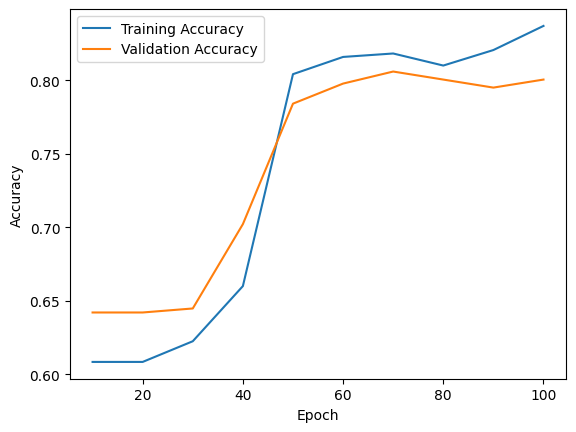

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning

model_KNN = KNeighborsClassifier(n_neighbors = 10)

warnings.filterwarnings("ignore", category=ConvergenceWarning)

training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):

    model_KNN.fit(X_train[:step], Y_train[:step])

    train_predictions = model_KNN.predict(X_train)

    val_predictions = model_KNN.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Testing

In [ ]:
model_KNN = KNeighborsClassifier(n_neighbors = 10)
model_KNN.fit(X_train, Y_train)
y_pred = model_KNN.predict(X_test)
print(f'Accuracy for ADA boost model is : {accuracy_score(y_pred, Y_test)*100} %')

C = confusion_matrix(Y_test,y_pred)
tn, fp, fn, tp = C.ravel()
print()
print(f'False Positive Calculted : {(fp / (fp + tn))*100} %')
print(f'False Negative Calculted : {(fn / (fn + tp))*100} %')

Accuracy for ADA boost model is : 90.49180327868852 %

False Positive Calculted : 3.1914893617021276 %
False Negative Calculted : 19.65811965811966 %


## *8. Linear Discriminant Analysis*


Training and Validation of 100 epoch of step 10

Step 10: Training Accuracy = 0.6952, Validation Accuracy = 0.6913
Step 20: Training Accuracy = 0.6893, Validation Accuracy = 0.6803
Step 30: Training Accuracy = 0.7444, Validation Accuracy = 0.7459
Step 40: Training Accuracy = 0.8148, Validation Accuracy = 0.7978
Step 50: Training Accuracy = 0.8324, Validation Accuracy = 0.8005
Step 60: Training Accuracy = 0.8359, Validation Accuracy = 0.8033
Step 70: Training Accuracy = 0.8499, Validation Accuracy = 0.8224
Step 80: Training Accuracy = 0.8675, Validation Accuracy = 0.8115
Step 90: Training Accuracy = 0.8605, Validation Accuracy = 0.8060
Step 100: Training Accuracy = 0.8722, Validation Accuracy = 0.8251


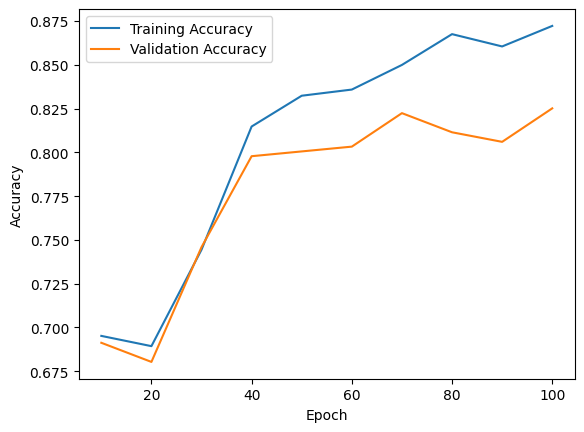

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning

model_LDA = LinearDiscriminantAnalysis()

warnings.filterwarnings("ignore", category=ConvergenceWarning)

training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):

    model_LDA.fit(X_train[:step], Y_train[:step])

    train_predictions = model_LDA.predict(X_train)

    val_predictions = model_LDA.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



Testing

In [ ]:
model_LDA = LinearDiscriminantAnalysis()
model_LDA.fit(X_train, Y_train)
y_pred = model_LDA.predict(X_test)
print(f'Accuracy for LDA model is : {accuracy_score(y_pred, Y_test)*100} %')

C = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = C.ravel()
print()
print(f'False Positive Calculated : {(fp / (fp + tn))*100} %')
print(f'False Negative Calculated : {(fn / (fn + tp))*100} %')

Accuracy for LDA model is : 78.36065573770492 %

False Positive Calculated : 19.148936170212767 %
False Negative Calculated : 25.64102564102564 %


## *9. Quadratic Discriminant Analysis*

Training and Validation of 100 epoch of step 10

Step 10: Training Accuracy = 0.5287, Validation Accuracy = 0.4617
Step 20: Training Accuracy = 0.6131, Validation Accuracy = 0.6148
Step 30: Training Accuracy = 0.6131, Validation Accuracy = 0.5546
Step 40: Training Accuracy = 0.7280, Validation Accuracy = 0.7158
Step 50: Training Accuracy = 0.7655, Validation Accuracy = 0.7404
Step 60: Training Accuracy = 0.6565, Validation Accuracy = 0.5738
Step 70: Training Accuracy = 0.6448, Validation Accuracy = 0.6421
Step 80: Training Accuracy = 0.6530, Validation Accuracy = 0.5820
Step 90: Training Accuracy = 0.6413, Validation Accuracy = 0.6066
Step 100: Training Accuracy = 0.7186, Validation Accuracy = 0.6503


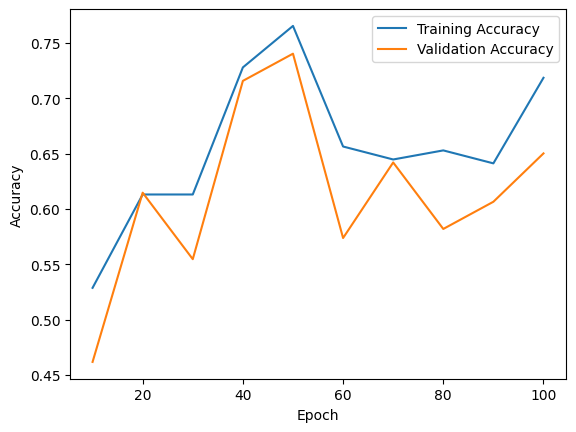

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
model_QDA = QuadraticDiscriminantAnalysis()

training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):

    model_QDA.fit(X_train[:step], Y_train[:step])

    train_predictions = model_QDA.predict(X_train)

    val_predictions = model_QDA.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing

In [ ]:
y_pred = model_QDA.predict(X_test)
model_QDA.fit(X_train, Y_train)
print(f'Accuracy for QDA model is : {accuracy_score(y_pred, Y_test)*100} %')

C = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = C.ravel()
print()
print(f'False Positive Calculated : {(fp / (fp + tn))*100} %')
print(f'False Negative Calculated : {(fn / (fn + tp))*100} %')

Accuracy for QDA model is : 68.52459016393443 %

False Positive Calculated : 34.57446808510639 %
False Negative Calculated : 26.495726495726498 %


## *10. Gradiant Boosting Machines*

Training and Validation of 100 epoch of step 10

Step 10: Training Accuracy = 0.6131, Validation Accuracy = 0.6448
Step 20: Training Accuracy = 0.6143, Validation Accuracy = 0.5902
Step 30: Training Accuracy = 0.6436, Validation Accuracy = 0.6612
Step 40: Training Accuracy = 0.7620, Validation Accuracy = 0.7596
Step 50: Training Accuracy = 0.7796, Validation Accuracy = 0.7705
Step 60: Training Accuracy = 0.8066, Validation Accuracy = 0.8033
Step 70: Training Accuracy = 0.9074, Validation Accuracy = 0.9044
Step 80: Training Accuracy = 0.8499, Validation Accuracy = 0.8415
Step 90: Training Accuracy = 0.9355, Validation Accuracy = 0.9153
Step 100: Training Accuracy = 0.9379, Validation Accuracy = 0.9071


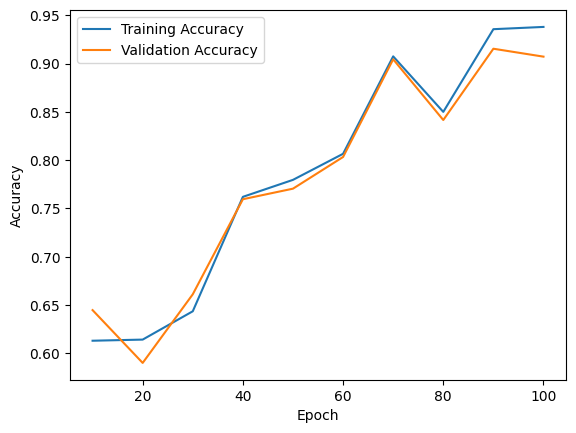

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

model_GBM = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0)

warnings.filterwarnings("ignore", category=ConvergenceWarning)

training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):
    model_GBM.fit(X_train[:step], Y_train[:step])

    train_predictions = model_GBM.predict(X_train)
    val_predictions = model_GBM.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing

In [ ]:
model_GBM = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0)
model_GBM.fit(X_train, Y_train)
y_pred = model_GBM.predict(X_test)
print(f'Accuracy for GBM model is: {accuracy_score(y_pred, Y_test) * 100} %')

C = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = C.ravel()
print()
print(f'False Positive Calculated: {(fp / (fp + tn)) * 100} %')
print(f'False Negative Calculated: {(fn / (fn + tp)) * 100} %')

Accuracy for GBM model is: 97.04918032786885 %

False Positive Calculated: 2.6595744680851063 %
False Negative Calculated: 3.418803418803419 %


## *11. Nearest Centroid*

Training and Validation of 100 epochs




Step 10: Training Accuracy = 0.6741, Validation Accuracy = 0.6803
Step 20: Training Accuracy = 0.7011, Validation Accuracy = 0.6940
Step 30: Training Accuracy = 0.7620, Validation Accuracy = 0.7650
Step 40: Training Accuracy = 0.7972, Validation Accuracy = 0.7896
Step 50: Training Accuracy = 0.8148, Validation Accuracy = 0.8087
Step 60: Training Accuracy = 0.8476, Validation Accuracy = 0.8142
Step 70: Training Accuracy = 0.8429, Validation Accuracy = 0.8169
Step 80: Training Accuracy = 0.8417, Validation Accuracy = 0.8197
Step 90: Training Accuracy = 0.8464, Validation Accuracy = 0.8169
Step 100: Training Accuracy = 0.8429, Validation Accuracy = 0.8169


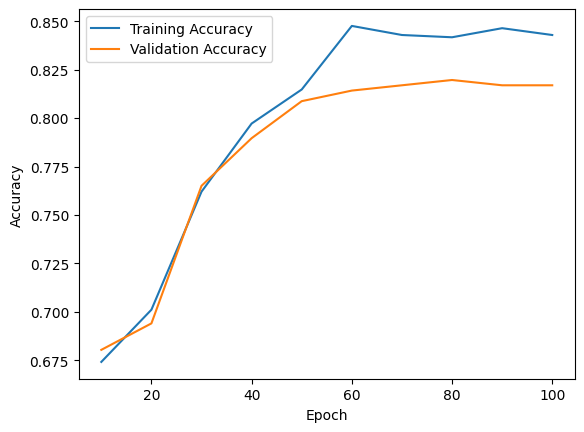

In [ ]:
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

model_NC = NearestCentroid()

warnings.filterwarnings("ignore", category=ConvergenceWarning)

training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):

    model_NC.fit(X_train[:step], Y_train[:step])

    train_predictions = model_NC.predict(X_train)

    val_predictions = model_NC.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing

In [ ]:
model_NC = NearestCentroid()
model_NC.fit(X_train,Y_train)
y_pred = model_NC.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
print(f'Accuracy for Nearest Centroid model is: {accuracy * 100} %')
print()
C = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = C.ravel()
print(f'False Positive Calculated: {(fp / (fp + tn)) * 100} %')
print(f'False Negative Calculated: {(fn / (fn + tp))*100} %')

Accuracy for Nearest Centroid model is: 80.65573770491802 %

False Positive Calculated: 23.93617021276596 %
False Negative Calculated: 11.965811965811966 %


## *12. CAT Boost*

Training and Validation of 100 epochs with step 10

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.1 MB/s eta 0:00:00


Step 10: Training Accuracy = 0.6143, Validation Accuracy = 0.6448
Step 20: Training Accuracy = 0.6190, Validation Accuracy = 0.6448
Step 30: Training Accuracy = 0.6495, Validation Accuracy = 0.6667
Step 40: Training Accuracy = 0.7257, Validation Accuracy = 0.7322
Step 50: Training Accuracy = 0.8980, Validation Accuracy = 0.8852
Step 60: Training Accuracy = 0.9050, Validation Accuracy = 0.9126
Step 70: Training Accuracy = 0.9121, Validation Accuracy = 0.9153
Step 80: Training Accuracy = 0.9086, Validation Accuracy = 0.8962
Step 90: Training Accuracy = 0.9109, Validation Accuracy = 0.8825
Step 100: Training Accuracy = 0.9062, Validation Accuracy = 0.8852


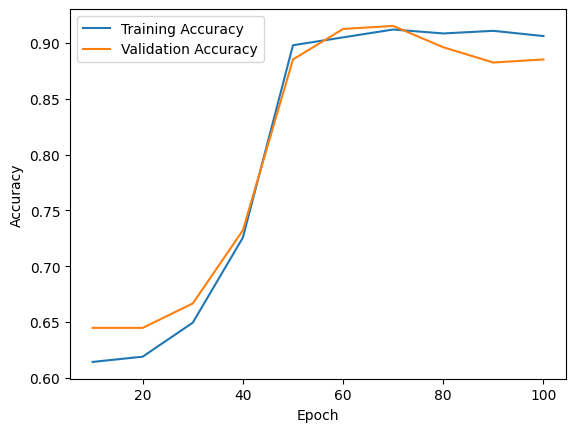

In [ ]:
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

model_catboost = CatBoostClassifier()

warnings.filterwarnings("ignore", category=ConvergenceWarning)

training_accuracy = []
validation_accuracy = []

for step in range(10, 101, 10):

    model_catboost.fit(X_train[:step], Y_train[:step], verbose=False)

    train_predictions = model_catboost.predict(X_train)
    val_predictions = model_catboost.predict(X_val)

    train_accuracy = accuracy_score(Y_train, train_predictions)
    val_accuracy = accuracy_score(Y_val, val_predictions)

    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f'Step {step}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

plt.plot(range(10, 101, 10), training_accuracy, label='Training Accuracy')
plt.plot(range(10, 101, 10), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Testing

In [ ]:
y_pred_catboost = model_catboost.predict(X_test)

accuracy_catboost = accuracy_score(y_pred_catboost, Y_test) * 100
print(f'Accuracy for CatBoost model is: {accuracy_catboost} %')

print()
C = confusion_matrix(Y_test, y_pred_catboost)
tn, fp, fn, tp = C.ravel()
fpr = (fp / (fp + tn)) * 100
fnr = (fn / (fn + tp)) * 100
print(f'False Positive Rate calculated: {fpr} %')
print(f'False Negative Rate calculated: {fnr} %')

Accuracy for CatBoost model is: 90.49180327868852 %

False Positive Rate calculated: 12.23404255319149 %
False Negative Rate calculated: 5.128205128205128 %


## *13. Deep Learning Model*

Training and Validation of 100 epoch of step 10

In [ ]:
import tensorflow as tf

Epoch 1/100
27/27 [==============================] - 4s 15ms/step - loss: 0.5225 - accuracy: 0.6682 - val_loss: 0.3947 - val_accuracy: 0.8989
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 0.3611 - accuracy: 0.8335 - val_loss: 0.2887 - val_accuracy: 0.8989
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 0.2702 - accuracy: 0.8828 - val_loss: 0.2617 - val_accuracy: 0.9098
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 0.2023 - accuracy: 0.9215 - val_loss: 0.2515 - val_accuracy: 0.8934
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 0.1814 - accuracy: 0.9308 - val_loss: 0.2251 - val_accuracy: 0.9180
Epoch 6/100
27/27 [==============================] - 0s 7ms/step - loss: 0.1558 - accuracy: 0.9484 - val_loss: 0.2005 - val_accuracy: 0.9590
Epoch 7/100
27/27 [==============================] - 0s 7ms/step - loss: 0.1181 - accuracy: 0.9590 - val_loss: 0.1926 - val_accuracy: 0.9481
Epoch 8/100


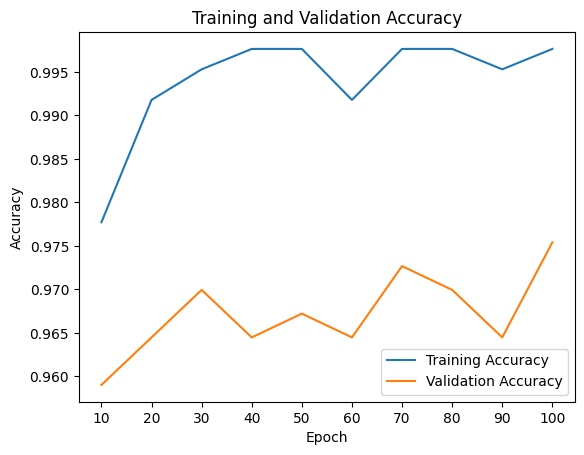

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


model_DL = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model_DL.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model_DL.fit(X_train, Y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, Y_val))

epochs_to_plot = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracy_train = [history.history['accuracy'][i-1] for i in epochs_to_plot]
accuracy_val = [history.history['val_accuracy'][i-1] for i in epochs_to_plot]

plt.plot(np.arange(len(accuracy_train)) * 10 + 10, accuracy_train, label='Training Accuracy')
plt.plot(np.arange(len(accuracy_val)) * 10 + 10, accuracy_val, label='Validation Accuracy')
plt.xticks(np.arange(len(accuracy_train)) * 10 + 10, epochs_to_plot)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Testing

In [ ]:
from sklearn.metrics import confusion_matrix
test_loss, test_accuracy = model_DL.evaluate(X_test, Y_test, verbose=0)

y_pred_temp = model_DL.predict(X_test).flatten()
y_pred = [1 if pred >= 0.5 else 0 for pred in y_pred]

C = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = C.ravel()

fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f'Accuracy: {test_accuracy*100} %')
print()
print(f'FPR: {fpr*100} %')
print(f'FNR: {fnr*100} %')

10/10 [==============================] - 0s 3ms/step
Accuracy: 97.37704992294312 %

FPR: 23.93617021276596 %
FNR: 11.965811965811966 %


# **RESPONSE CURVE OF ALL MODELS**

Learning rate set to 0.009626
0:	learn: 0.6811353	total: 59.1ms	remaining: 59s
1:	learn: 0.6715813	total: 110ms	remaining: 54.7s
2:	learn: 0.6617429	total: 160ms	remaining: 53.3s
3:	learn: 0.6485312	total: 216ms	remaining: 53.9s
4:	learn: 0.6392698	total: 274ms	remaining: 54.4s
5:	learn: 0.6308183	total: 327ms	remaining: 54.2s
6:	learn: 0.6214260	total: 372ms	remaining: 52.8s
7:	learn: 0.6125785	total: 424ms	remaining: 52.5s
8:	learn: 0.6052101	total: 470ms	remaining: 51.7s
9:	learn: 0.5960046	total: 521ms	remaining: 51.5s
10:	learn: 0.5875708	total: 570ms	remaining: 51.3s
11:	learn: 0.5793999	total: 616ms	remaining: 50.7s
12:	learn: 0.5714475	total: 671ms	remaining: 50.9s
13:	learn: 0.5631503	total: 723ms	remaining: 50.9s
14:	learn: 0.5560313	total: 772ms	remaining: 50.7s
15:	learn: 0.5483043	total: 825ms	remaining: 50.8s
16:	learn: 0.5429120	total: 875ms	remaining: 50.6s
17:	learn: 0.5359297	total: 929ms	remaining: 50.7s
18:	learn: 0.5290842	total: 973ms	remaining: 50.3s
19:	learn: 0

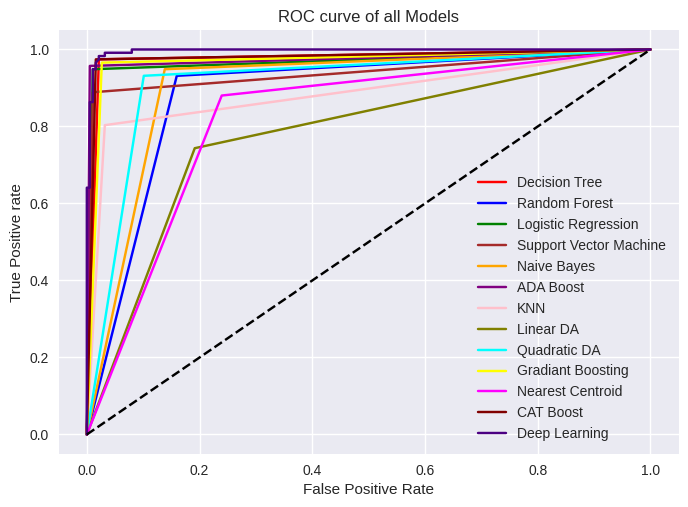

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Models = [model_DTC, model_RFC, model_LRC, model_SVC, model_GNB, model_ADA, model_KNN, model_LDA, model_QDA, model_GBM, model_NC, model_catboost, model_DL]
Colors = ['Red','Blue','Green','Brown','Orange','Purple','Pink','Olive','Cyan','Yellow','Magenta','Maroon','Indigo']
Labels = ['Decision Tree','Random Forest','Logistic Regression','Support Vector Machine','Naive Bayes','ADA Boost','KNN','Linear DA','Quadratic DA','Gradiant Boosting','Nearest Centroid','CAT Boost','Deep Learning']

random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

for i,j,k in zip(Models, Colors, Labels):
  i.fit(X_train, Y_train)
  pred_i = i.predict(X_test)

  fpr_i, tpr_i, thresh_i = roc_curve(Y_test, pred_i, pos_label=1)

  plt.plot(fpr_i, tpr_i, color=j, label=k)

plt.plot(p_fpr, p_tpr, linestyle='--', color='Black')
plt.title('ROC curve of all Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show();

# Labels Extraction

In [ ]:
df = pd.DataFrame({'Predicted Label': y_pred, 'True Label': Y_test})

df.to_excel('13.Deep Learning Classifier_prediction.xlsx', index=False)